In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import seaborn as sns
import tensorflow as tf

import helpers, config

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 100

CTACCTCA


In [2]:
baselines = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/biochem_baselines.txt',
                        sep='\t', index_col='gene')
baselines.head()

,baseline
gene,
NM_000019,5.610010
NM_000031,3.349284
NM_000046,3.985318
NM_000064,2.396410
NM_000086,4.372329


In [3]:
TEST_MIRS = sorted(['mir153','mir139','mir144','mir223','mir137',
             'mir205','mir143','mir182','mir199a','mir204','mir216b'])

MIRS5 = ['mir1','mir124','mir155','mir7','lsy6']
MIRS6 = ['mir1','mir124','mir155','mir7','lsy6','let7']
ALL_MIRS = MIRS5 + TEST_MIRS


MERGED = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/merged.txt',
                     sep='\t', index_col=0)
MERGED = pd.concat([MERGED, baselines], axis=1, join='inner')
MERGED.head()

,let7,lsy6,mir1,mir124,mir137,mir139,mir143,mir144,mir153,mir155,mir182,mir199a,mir204,mir205,mir216b,mir223,mir7,sequence,orf_length,utr_length,ix,nosite1,nosite2,nosite3,baseline
gene,,,,,,,,,,,,,,,,,,,,,,,,,
NM_000019,5.472150,5.538776,5.577042,5.649801,5.406582,5.492721,5.606229,5.570015,5.530304,5.684962,5.748195,5.631658,5.551187,5.495191,5.559670,5.615164,5.677916,ACAACCTCTGCTATTTAAGGAGACAACCCTATGTGACCAGAAGGCC...,1281,209,0,5.586729,5.584360,5.586729,5.610010
NM_000031,3.218292,3.063797,3.151540,3.115912,3.189741,3.013276,3.319983,3.343367,3.082736,3.293842,3.204595,3.249728,3.060618,2.950676,3.074226,3.191090,3.515169,TGGAGACAGTGCCAGGCCCAAGAACTAGAACTTTAAAACGTTCCCG...,990,1987,1,3.319983,3.135829,3.319983,3.349284
NM_000046,4.081735,4.241248,4.070133,4.320221,3.841543,4.060270,4.090714,4.291743,4.098148,4.202921,4.064411,4.174584,4.290780,3.963390,3.911022,4.160757,3.020435,GATTTCAGGGAGGCTAGAAAACCTTTCAATTGGAAGTTGGACCTCA...,1599,53,2,4.050145,4.050145,4.050145,3.985318
NM_000064,2.484637,2.383718,2.251052,2.343596,2.386032,2.689175,2.633429,2.548864,3.206306,2.171506,3.123980,2.659572,2.856986,3.027227,2.453375,2.744231,2.674473,CCACACCCCCATTCCCCCACTCCAGATAAAGCTTCAGTTATATCTC,4989,46,3,2.660165,2.660165,2.660165,2.396410
NM_000086,4.167220,4.529920,4.291420,4.354404,4.371496,4.481273,4.430950,4.458488,4.478760,4.438987,4.477172,4.605044,4.642986,4.597139,4.603487,4.514120,3.898598,TACTCGGGATCCTCAGGACGCAGGTCACATTCACCTGTGGGCAGAG...,1314,236,4,4.495382,4.498903,4.500506,4.372329


In [4]:
kds = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/kds.txt',sep='\t')
kds.head()

,12mer,log_kd,mir,mirseq,stype
0,AAAAAATCCAAA,-0.810633,mir1,TGGAATGTAAAGAAGTATGTAT,no site
1,AAAAAATCCAAC,-1.805606,mir1,TGGAATGTAAAGAAGTATGTAT,no site
2,AAAAAATCCAAG,-0.287849,mir1,TGGAATGTAAAGAAGTATGTAT,no site
3,AAAAAATCCAAT,-0.206237,mir1,TGGAATGTAAAGAAGTATGTAT,no site
4,AAAAAATCCACA,-1.096425,mir1,TGGAATGTAAAGAAGTATGTAT,no site


In [5]:
# kd_dinuc_model = kds.copy()
# kd_dinuc_model['up'] = [x[:2] for x in kd_dinuc_model['12mer']]
# kd_dinuc_model['down'] = [x[-2:] for x in kd_dinuc_model['12mer']]
# kd_dinuc_model['A1'] = [x[-3] for x in kd_dinuc_model['12mer']]
# for ix in range(6):
#     kd_dinuc_model['pos_{}'.format(ix)] = [x[:2] for x in kd_dinuc_model['12mer']]

In [5]:
kd_features = kds.copy()
kd_features['core'] = [x[2:-3] for x in kd_features['12mer']]
kd_features['up'] = [x[:2] for x in kd_features['12mer']]
kd_features['down'] = [x[-2:] for x in kd_features['12mer']]
kd_features['A1'] = [x[-3] for x in kd_features['12mer']]
kd_features.head()

,12mer,log_kd,mir,mirseq,stype,core,up,down,A1
0,AAAAAATCCAAA,-0.810633,mir1,TGGAATGTAAAGAAGTATGTAT,no site,AAAATCC,AA,AA,A
1,AAAAAATCCAAC,-1.805606,mir1,TGGAATGTAAAGAAGTATGTAT,no site,AAAATCC,AA,AC,A
2,AAAAAATCCAAG,-0.287849,mir1,TGGAATGTAAAGAAGTATGTAT,no site,AAAATCC,AA,AG,A
3,AAAAAATCCAAT,-0.206237,mir1,TGGAATGTAAAGAAGTATGTAT,no site,AAAATCC,AA,AT,A
4,AAAAAATCCACA,-1.096425,mir1,TGGAATGTAAAGAAGTATGTAT,no site,AAAATCC,AA,CA,A


In [6]:
kd_cores = kd_features.groupby(['mir','core']).first().reset_index()
kd_cores.head()

,mir,core,12mer,log_kd,mirseq,stype,up,down,A1
0,let7,AAAACTC,AAAAAACTCAAA,-0.439165,TGAGGTAGTAGGTTGTATAGTT,no site,AA,AA,A
1,let7,AAACCTA,AAAAACCTAAAA,-0.443004,TGAGGTAGTAGGTTGTATAGTT,no site,AA,AA,A
2,let7,AAACCTC,AAAAACCTCAAA,-3.211067,TGAGGTAGTAGGTTGTATAGTT,6mer-a1,AA,AA,A
3,let7,AAACCTG,AAAAACCTGAAA,-0.425993,TGAGGTAGTAGGTTGTATAGTT,no site,AA,AA,A
4,let7,AAACCTT,AAAAACCTTAAA,-0.050612,TGAGGTAGTAGGTTGTATAGTT,no site,AA,AA,A


In [7]:
with open('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/ConvNet/for_rnaduplex.txt','w') as outfile:
    for row in kd_cores.iterrows():
        outfile.write('{}\n{}\n'.format(row[1]['mirseq'][1:8], row[1]['core']))
            

In [8]:
dGs = []
with open('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/ConvNet/rnaduplex_out.txt','r') as infile:
    for line in infile.readlines():
        dG = float(line.split(':')[-1].split('(')[-1].split(')')[0])
        dGs.append(dG)

kd_cores['deltaG'] = dGs
kd_cores_bymir = {x: group.set_index('core') for (x, group) in kd_cores.groupby('mir')}
kd_cores_bymir['mir1'].head()

,mir,12mer,log_kd,mirseq,stype,up,down,A1,deltaG
core,,,,,,,,,
AAAATCC,mir1,AAAAAATCCAAA,-0.810633,TGGAATGTAAAGAAGTATGTAT,no site,AA,AA,A,-1.9
AAACTCC,mir1,AAAAACTCCAAA,-1.205471,TGGAATGTAAAGAAGTATGTAT,no site,AA,AA,A,-2.1
AAAGTCC,mir1,AAAAAGTCCAAA,0.198650,TGGAATGTAAAGAAGTATGTAT,no site,AA,AA,A,-1.9
AAATTCA,mir1,AAAAATTCAAAA,-0.485575,TGGAATGTAAAGAAGTATGTAT,no site,AA,AA,A,-2.3
AAATTCC,mir1,AAAAATTCCAAA,-2.277651,TGGAATGTAAAGAAGTATGTAT,6mer-a1,AA,AA,A,-4.2


In [9]:
kd_features_all = []
for mir, group in kd_features.groupby('mir'):
    group['core_dG'] = kd_cores_bymir[mir].loc[group['core'].values]['deltaG'].values
    kd_features_all.append(group)
    
kd_features_all = pd.concat(kd_features_all)
kd_features_all.head()

,12mer,log_kd,mir,mirseq,stype,core,up,down,A1,core_dG
1310720,AAAAAACTCAAA,-0.439165,let7,TGAGGTAGTAGGTTGTATAGTT,no site,AAAACTC,AA,AA,A,-2.0
1310721,AAAAAACTCAAC,-0.574668,let7,TGAGGTAGTAGGTTGTATAGTT,no site,AAAACTC,AA,AC,A,-2.0
1310722,AAAAAACTCAAG,0.300351,let7,TGAGGTAGTAGGTTGTATAGTT,no site,AAAACTC,AA,AG,A,-2.0
1310723,AAAAAACTCAAT,-0.172328,let7,TGAGGTAGTAGGTTGTATAGTT,no site,AAAACTC,AA,AT,A,-2.0
1310724,AAAAAACTCACA,-0.365319,let7,TGAGGTAGTAGGTTGTATAGTT,no site,AAAACTC,AA,CA,A,-2.0


In [10]:
formula = 'log_kd ~ core_dG + C(up) + C(down) + C(A1)'
# formula = 'log_kd ~ (core_dG + C(A1)) : (core_dG + C(A1)) + C(up) + C(down)'
# mod = smf.ols(formula=formula, data=kd_features_all[kd_features_all['log_kd'] < 0]).fit()
mod = smf.ols(formula=formula, data=kd_features_all[kd_features_all['stype'] != 'no site']).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_kd   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     717.3
Date:                Wed, 01 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:15:06   Log-Likelihood:            -1.0228e+05
No. Observations:               61440   AIC:                         2.046e+05
Df Residuals:                   61405   BIC:                         2.049e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5544      0.032    -48.324      0.000      -1.617      -1.491
C(up)[T.AC]       0.6806      0.029     23.318      0.000       0.623       0.738
C(up)[T.AG]       0.8307      0.029     28.459      0.000       0.773       0.888
C(up)[T.AT]       0.2236      0.029      7.659      0.000       0.166       0.281
C(up)[T.CA]       0.5456      0.029     18.692      0.000       0.488       0.603
C(up)[T.CC]       1.0080      0.029     34.534      0.000       0.951       1.065
C(up)[T.CG]       1.2704      0.029     43.525      0.000       1.213       1.328
C(up)[T.CT]       0.9653      0.029     33.072      0.000       0.908       1.022
C(up)[T.GA]       0.8873      0.029     30.399      0.000       0.830       0.944
C(up)[T.GC]       1.4537      0.029     49.806      0.000       1.397       1.511
C(up)[T.GG]       1.8927      0.029     64.845      0.000       1.835       1.950
C(up)[T.GT]       1.0502      0.029     35.980      0.000       0.993       1.107
C(up)[T.TA]       0.2778      0.029      9.519      0.000       0.221       0.335
C(up)[T.TC]       0.8937      0.029     30.619      0.000       0.836       0.951
C(up)[T.TG]       1.0857      0.029     37.196      0.000       1.028       1.143
C(up)[T.TT]       0.4877      0.029     16.709      0.000       0.430       0.545
C(down)[T.AC]     0.2501      0.029      8.570      0.000       0.193       0.307
C(down)[T.AG]     0.4490      0.029     15.384      0.000       0.392       0.506
C(down)[T.AT]     0.0724      0.029      2.481      0.013       0.015       0.130
C(down)[T.CA]     0.2393      0.029      8.200      0.000       0.182       0.297
C(down)[T.CC]     0.5076      0.029     17.392      0.000       0.450       0.565
C(down)[T.CG]     0.6444      0.029     22.079      0.000       0.587       0.702
C(down)[T.CT]     0.3522      0.029     12.065      0.000       0.295       0.409
C(down)[T.GA]     0.6067      0.029     20.787      0.000       0.550       0.664
C(down)[T.GC]     0.5487      0.029     18.799      0.000       0.491       0.606
C(down)[T.GG]     0.8045      0.029     27.564      0.000       0.747       0.862
C(down)[T.GT]     0.6226      0.029     21.331      0.000       0.565       0.680
C(down)[T.TA]    -0.0138      0.029     -0.473      0.636      -0.071       0.043
C(down)[T.TC]     0.2598      0.029      8.900      0.000       0.203       0.317
C(down)[T.TG]     0.4268      0.029     14.623      0.000       0.370       0.484
C(down)[T.TT]    -0.0225      0.029     -0.771      0.440      -0.080       0.035
C(A1)[T.C]        0.3891      0.015     26.290      0.000       0.360       0.418
C(A1)[T.G]        0.6208      0.015     41.952      0.000       0.592       0.650
C(A1)[T.T]        0.0946      0.015      6.391      0.000       0.066       0.124
core_dG           0.2911      0.003    113.885   

In [20]:
kd_features_all['pred'] = mod.predict(exog=kd_features_all)

In [35]:
for mir, group in kd_features_all.groupby('mir'):
    site = config.SITE_DICT[mir]
    print(len(group))
    group['has_offset'] = [(((site[2:] in seq) or (site[1:-1] in seq) or (site[:-2] in seq)) and (stype == 'no site')) for (seq, stype) in zip(group['12mer'], group['stype'])]
    group = group[group['has_offset'] == False]
    print(len(group))
    print(mir)
    print(stats.linregress(group['pred'], group['log_kd'])[2]**2)
    temp = group[group['pred'] < 0]
    print(stats.linregress(temp['pred'], temp['log_kd'])[2]**2)
    temp = group[group['stype'] != 'no site']
    print(stats.linregress(temp['pred'], temp['log_kd'])[2]**2)

262144
261680
let7
0.241573771661
0.230255665154
0.322633438573
262144
260640
lsy6
0.144507476267
0.0850446084855
0.313407545581
262144
262048
mir1
0.171544464026
0.143932720008
0.413612677985
262144
262048
mir124
0.0506631763952
0.0469323304209
0.308479134633
262144
261840
mir155
0.0571266964519
0.0381952642348
0.379531903133
262144
261776
mir7
0.091742762702
0.0950585899556
0.162178776998


In [11]:
kds_pred = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_all_mirs_fix_run2.txt',
                        sep='\t')

kds_pred2 = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_all_mirs_fix_getseqs2.txt',
                        sep='\t')
kds_pred = pd.concat([kds_pred[kds_pred['mir'].isin(['mir124','mir7'])],
                      kds_pred2[kds_pred2['mir'].isin(['mir1','mir155','lsy6','let7'])]])
kds_pred.head()

,12mer,log_kd,mir,stype
4456448,AGGTGCGCAAAG,0.959854,mir124,no site
4456449,TTTTGCCTGGTA,-0.994563,mir124,no site
4456450,CCTTACCTTCCC,0.691340,mir124,no site
4456451,CATCCTCTTATA,1.870322,mir124,no site
4456452,CGCGCCCTTGTG,1.105599,mir124,no site


In [12]:
new_df = []
for ix, mir in enumerate(MIRS6):
    temp1 = kds_pred[kds_pred['mir'] == mir].set_index('12mer').rename(columns = {'log_kd': 'pred'})
    temp2 = kds[kds['mir'] == mir]
    site = config.SITE_DICT[mir]
    print(len(temp2))
    temp2['has_offset'] = [(((site[2:] in seq) or (site[1:-1] in seq) or (site[:-2] in seq)) and (stype == 'no site')) for (seq, stype) in zip(temp2['12mer'], temp2['stype'])]
    temp2 = temp2[temp2['has_offset'] == False].set_index('12mer')
    print(len(temp2))
    print(mir)
    mir1 = pd.concat([temp1[['pred']], temp2[['log_kd','stype','has_offset','mir']]], axis=1, join='inner')

    print(stats.linregress(mir1['pred'], mir1['log_kd'])[2]**2)
    temp = mir1[mir1['pred'] < 0]
    print(stats.linregress(temp['pred'], temp['log_kd'])[2]**2)
    temp = mir1[mir1['stype'] != 'no site']
    print(stats.linregress(temp['pred'], temp['log_kd'])[2]**2)
    
    new_df.append(mir1)
    
new_df = pd.concat(new_df)
new_df.head()

262144
262048
mir1
0.178241699952
0.21611239523
0.58506651651
262144
262048
mir124
0.0506068247385
0.289606246594
0.490441724686
262144
261840
mir155
0.30167501346
0.403526683114
0.743129708554
262144
261776
mir7
0.110476521252
0.238900741816
0.521791795219
262144
260640
lsy6
0.188123061817
0.284972546183
0.669293861913
262144
261680
let7
0.394666540163
0.469788366735
0.705399828477


,pred,log_kd,stype,has_offset,mir
12mer,,,,,
AAAAAATCCAAA,-1.641022,-0.810633,no site,False,mir1
AAAAAATCCAAC,-1.602603,-1.805606,no site,False,mir1
AAAAAATCCAAG,-1.605717,-0.287849,no site,False,mir1
AAAAAATCCAAT,-1.648199,-0.206237,no site,False,mir1
AAAAAATCCACA,-1.498095,-1.096425,no site,False,mir1


In [82]:
np.median(kds[kds['stype'] == '6mer']['log_kd'])

-2.0566609399065872

In [21]:
print(stats.linregress(new_df['pred'], new_df['log_kd'])[2]**2)
print(stats.linregress(kd_features_all['pred'], kd_features_all['log_kd'])[2]**2)
temp1 = new_df[new_df['log_kd'] < -2]
temp2 = kd_features_all[kd_features_all['log_kd'] < -2]
print(stats.linregress(temp1['pred'], temp1['log_kd'])[2]**2)
print(stats.linregress(temp2['pred'], temp2['log_kd'])[2]**2)

0.139735280201
0.0639598769975
0.483414676135
0.109678978866


In [88]:
subset = np.random.choice(np.arange(len(new_df)), size=1000)

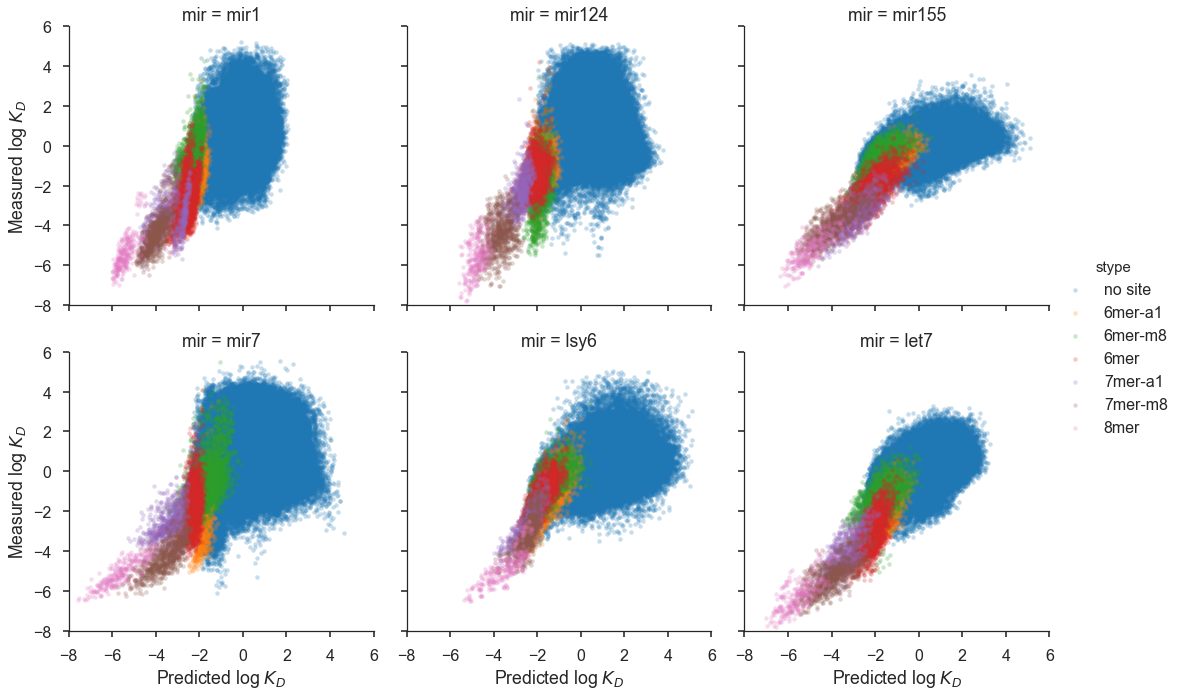

In [101]:
sns.set_context('poster')
g = sns.lmplot(x='pred', y='log_kd', hue='stype', data=new_df, col='mir', col_wrap=3,
           fit_reg=False, hue_order=['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer'],
              scatter_kws={'alpha':0.25, 's': 20})

g.set_axis_labels(r"Predicted log $K_D$", r"Measured log $K_D$")
g.set(xlim=[-8,6], ylim=[-8, 6], xticks=[-8,-6,-4,-2,0,2,4,6])

In [17]:
temp = new_df[new_df['mir'] == 'mir1']
temp = temp[temp['stype'] == 'no site']
temp.sort_values('log_kd').head()

,pred,log_kd,stype,has_offset,mir
12mer,,,,,
CTTCATTACATT,-1.190531,-4.112067,no site,False,mir1
TTTCATTACATT,-1.184376,-3.884081,no site,False,mir1
CTTCATTCATTC,-1.881325,-3.857888,no site,False,mir1
ATTCCTTCCTAA,-1.245469,-3.836374,no site,False,mir1
TTACATTACATT,-1.880850,-3.768171,no site,False,mir1


In [76]:
current_palette = sns.color_palette()
current_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [77]:
stypes = ['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer']
color_dict = {stypes[ix]: current_palette[ix] for ix in range(len(stypes))}
new_df['color'] = [color_dict[stype] for stype in new_df['stype']]

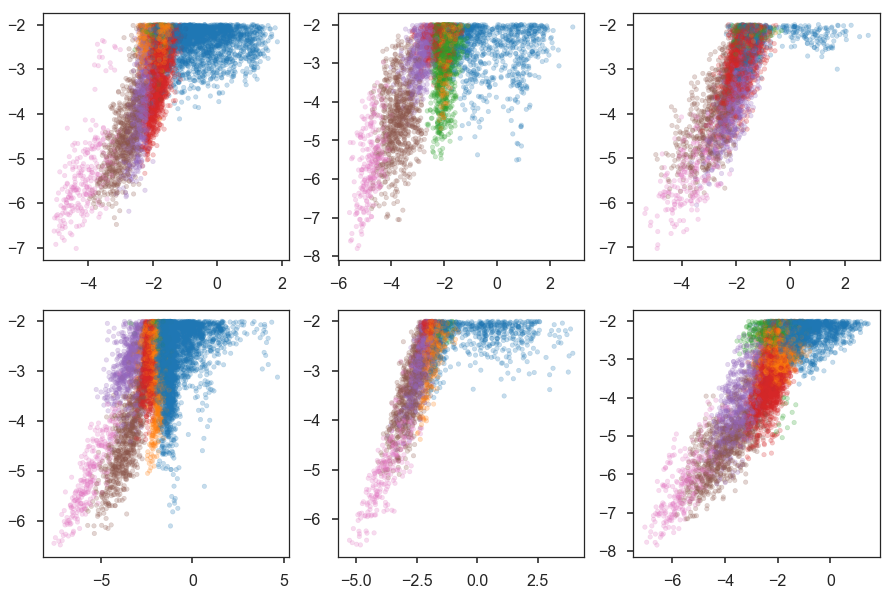

In [79]:
sns.set_style('ticks')
sns.set_context('poster')
fig = plt.figure(figsize=(15,10))
blah = new_df[new_df['log_kd'] < -2]
# blah = blah[blah['pred'] < 0]
for ix, mir in enumerate(MIRS6):
    ax = plt.subplot(2,3,ix+1)
    temp = blah[blah['mir'] == mir].sort_index()
    ax.scatter(temp['pred'], temp['log_kd'], color=temp['color'], s=20, alpha=0.25)

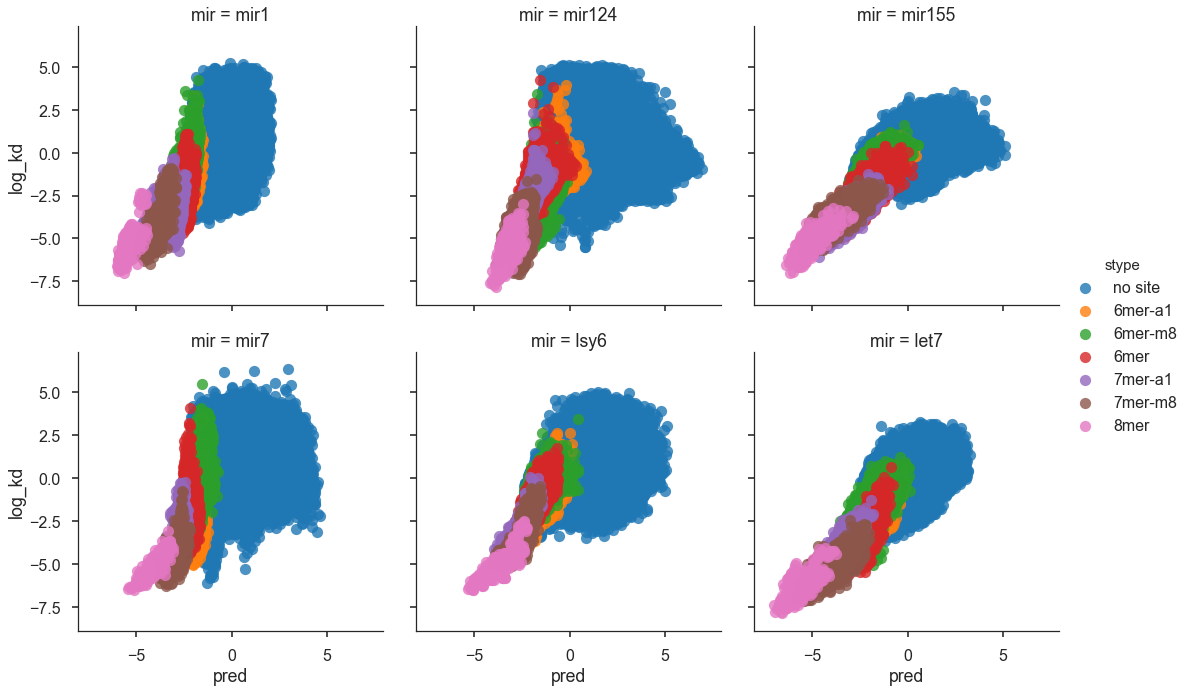

In [29]:
# real fix getseqs
sns.lmplot(x='pred', y='log_kd', hue='stype', data=new_df, col='mir',col_wrap=3,
           fit_reg=False, hue_order=['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer'])

In [16]:
temp = kds[kds['mir'] == 'mir1']
temp = temp[temp['stype'] == 'no site']
temp.sort_values('log_kd').head()

,12mer,log_kd,mir,mirseq,stype
247717,TTACATCATTCC,-4.834844,mir1,TGGAATGTAAAGAAGTATGTAT,no site
213997,TCACATACATTC,-4.776606,mir1,TGGAATGTAAAGAAGTATGTAT,no site
1005,AAACATACATTC,-4.739399,mir1,TGGAATGTAAAGAAGTATGTAT,no site
214949,TCACATCATTCC,-4.703857,mir1,TGGAATGTAAAGAAGTATGTAT,no site
83877,CCACATCATTCC,-4.648965,mir1,TGGAATGTAAAGAAGTATGTAT,no site


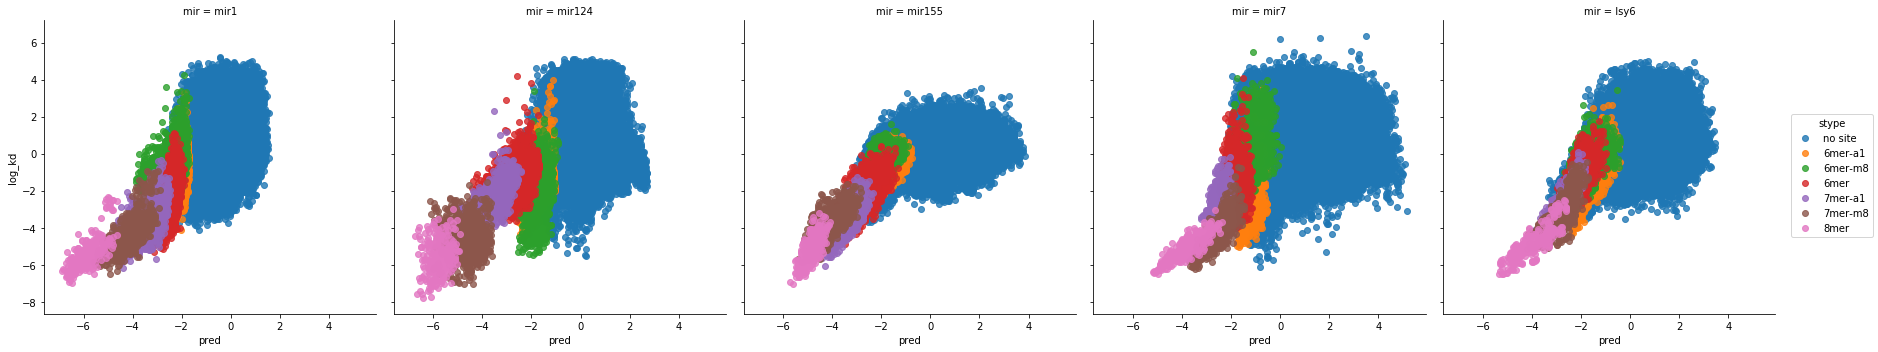

In [62]:
# run1
# sns.lmplot(x='pred', y='log_kd', hue='stype', data=new_df, col='mir',
#            fit_reg=False, hue_order=['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer'])

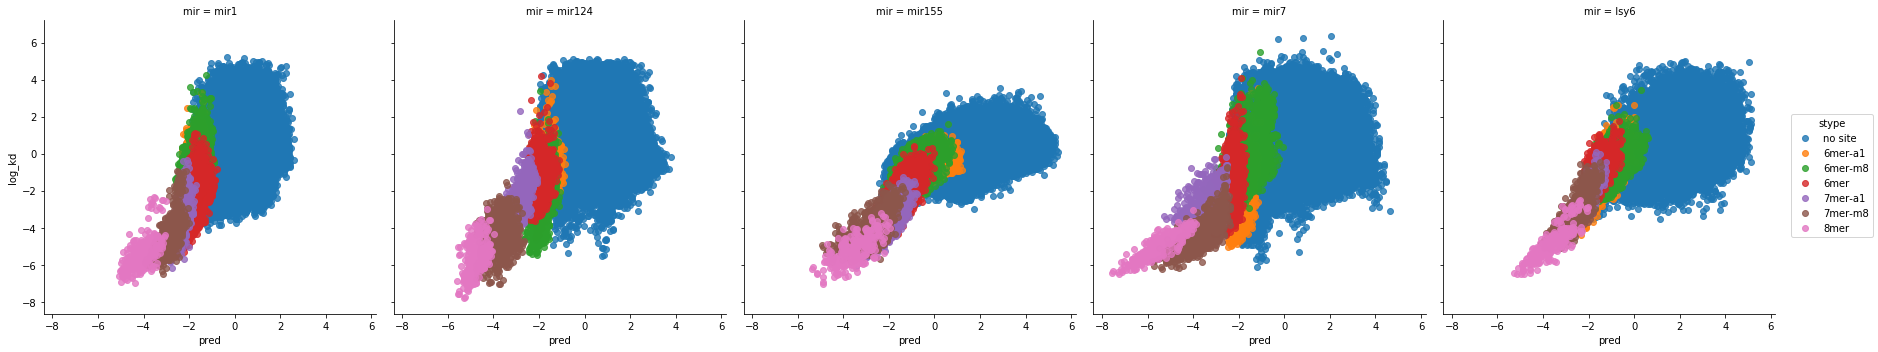

In [81]:
# run2
# sns.lmplot(x='pred', y='log_kd', hue='stype', data=new_df, col='mir',
#            fit_reg=False, hue_order=['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer'])

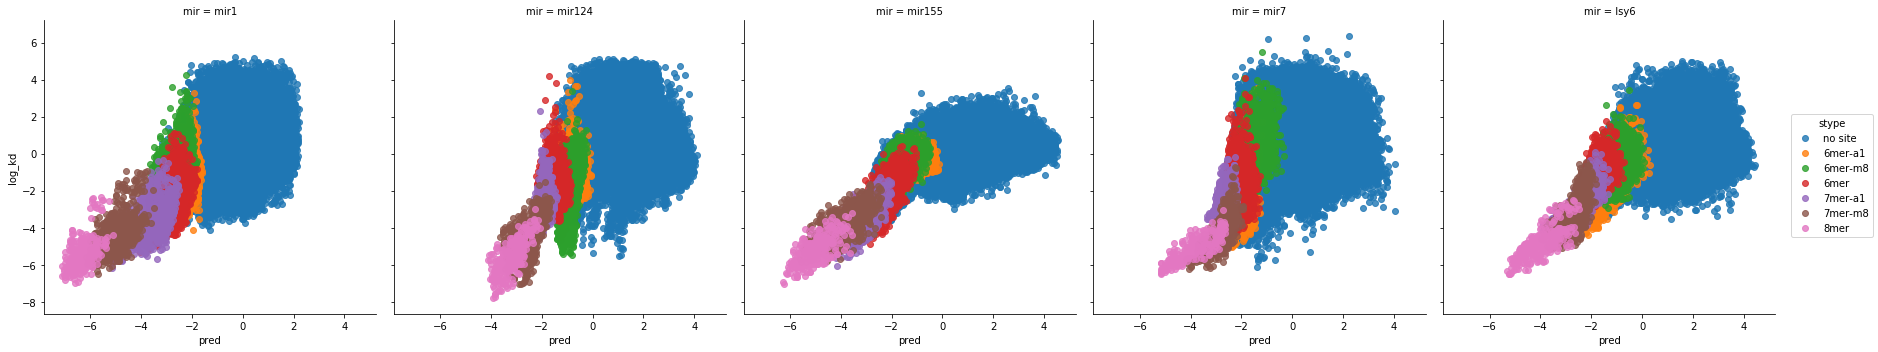

In [67]:
# run3 (fix_getseqs)
# sns.lmplot(x='pred', y='log_kd', hue='stype', data=new_df, col='mir',
#            fit_reg=False, hue_order=['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer'])

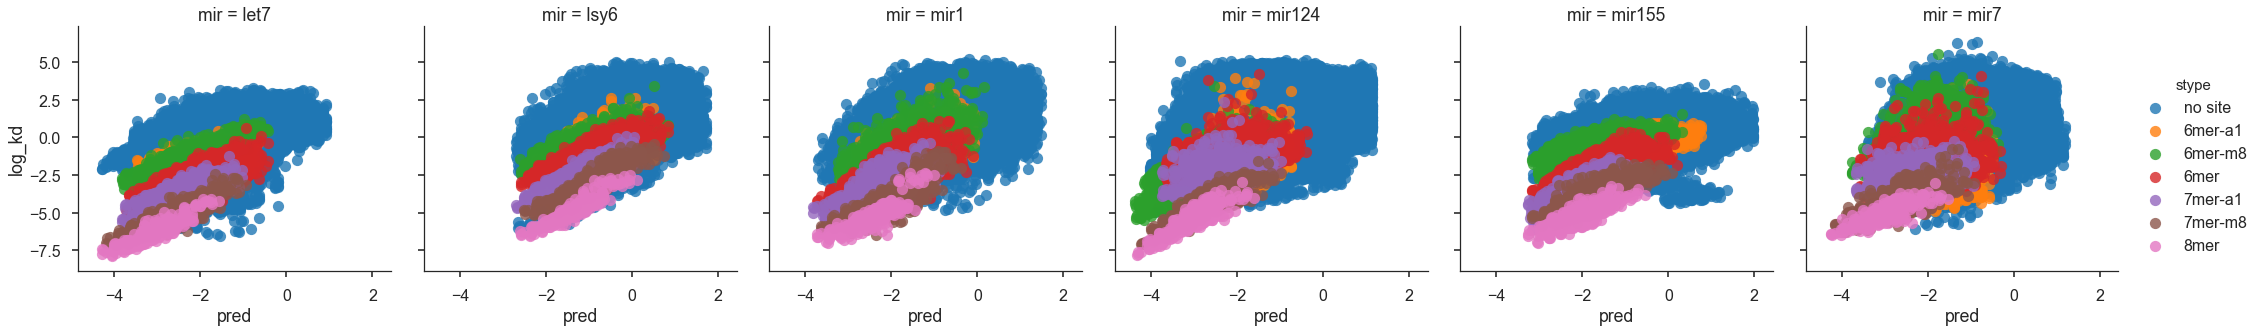

In [34]:
sns.lmplot(x='pred', y='log_kd', hue='stype', data=kd_features_all, col='mir',
           fit_reg=False, hue_order=['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer'])

In [63]:
human_miRNAs = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/TS7_files/miR_Family_Info7.txt',sep='\t')
human_miRNAs = human_miRNAs[human_miRNAs['Species ID'] == 9606]
human_miRNAs['10mer'] = [x[:10].replace('U','T') for x in human_miRNAs['Mature sequence']]
# human_miRNAs = human_miRNAs.groupby('10mer').first().reset_index()
cons_dict = {0: 'Poorly conserved', 1: 'Conserved', 2: 'Broadly conserved'}
human_miRNAs['cons'] = [cons_dict[x] for x in human_miRNAs['Family Conservation?']]
human_miRNAs.head()

,miR family,Seed+m8,Species ID,MiRBase ID,Mature sequence,Family Conservation?,MiRBase Accession,10mer,cons
5,miR-1-5p,CAUACUU,9606,hsa-miR-1-5p,ACAUACUUCUUUAUAUGCCCAU,0,MIMAT0031892,ACATACTTCT,Poorly conserved
10,miR-28-3p,ACUAGAU,9606,hsa-miR-28-3p,CACUAGAUUGUGAGCUCCUGGA,1,MIMAT0004502,CACTAGATTG,Conserved
16,miR-101-3p.2,UACAGUA,9606,hsa-miR-101-3p.2,GUACAGUACUGUGAUAACUGA,2,NaN,GTACAGTACT,Broadly conserved
25,miR-124-3p.2/506-3p,UAAGGCA,9606,hsa-miR-124-3p.2,UUAAGGCACGCGGUGAAUGC,2,NaN,TTAAGGCACG,Broadly conserved
26,miR-124-3p.2/506-3p,UAAGGCA,9606,hsa-miR-506-3p,GUAAGGCACCCUUCUGAGUAGA,2,-,GTAAGGCACC,Broadly conserved


In [17]:
mir_names = human_miRNAs['MiRBase ID'].values
temp_mirs = ['mir1','mir155','mir124','mir7','let7'] + TEST_MIRS
mir_to_name = {}
for mir_orig in temp_mirs:
    mir = (mir_orig.replace('mir','miR-').replace('let7', 'let-7a'))
    potential = [x for x in mir_names if mir in x]
    if len(potential) == 1:
        mir_to_name[mir_orig] = potential[0]
    else:
        potential = [x for x in potential if (mir + '-') in x]
        if len(potential) == 1:
            mir_to_name[mir_orig] = potential[0]
        else:
            mir_to_name[mir_orig] = potential[1]


In [30]:
import itertools as it
all_mirs = ["".join(kmer) for kmer in list(it.product(["A","C","G","T"],repeat=10))]
kds_all_mirs_x = np.zeros([len(all_mirs), 4*config.MIRLEN, 4*config.SEQLEN])
for i, mirseq in enumerate(all_mirs):
    mirseq = mirseq
    mirseq_one_hot = helpers.one_hot_encode(mirseq[:config.MIRLEN][::-1], config.MIR_NT_DICT, config.TARGETS)
    seq = 'AA' + helpers.rev_comp(mirseq[1:8]) + 'AAA'
    seq_one_hot = helpers.one_hot_encode(seq, config.SEQ_NT_DICT, config.TARGETS)
    kds_all_mirs_x[i,:,:] = np.outer(mirseq_one_hot, seq_one_hot)

kds_all_mirs_x = np.expand_dims((kds_all_mirs_x*4) - 0.25, 3)
print(kds_all_mirs_x.shape)

(1048576, 40, 48, 1)


In [22]:
test_kds_combined_x = np.zeros([len(human_miRNAs), 4*config.MIRLEN, 4*config.SEQLEN])
for i, row in enumerate(human_miRNAs.iterrows()):
    mirseq = row[1]['10mer']
    mirseq_one_hot = helpers.one_hot_encode(mirseq[:config.MIRLEN][::-1], config.MIR_NT_DICT, config.TARGETS)
    seq = 'AA' + helpers.rev_comp(mirseq[1:8]) + 'AAA'
    seq_one_hot = helpers.one_hot_encode(seq, config.SEQ_NT_DICT, config.TARGETS)
    test_kds_combined_x[i,:,:] = np.outer(mirseq_one_hot, seq_one_hot)

test_kds_combined_x = np.expand_dims((test_kds_combined_x*4) - 0.25, 3)   

In [31]:
log_dir = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/'
tf.reset_default_graph()
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    latest = tf.train.latest_checkpoint('{}/none/saved'.format(log_dir))
    print(latest)
    saver = tf.train.import_meta_graph(latest + '.meta')
    saver.restore(sess, latest)

    _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
    _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
    _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
    _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/pred_ka:0')

#     i = 0
#     for op in tf.get_default_graph().get_operations():
# #         print(str(op.name))
#         if 'final_layer' in str(op.name):
#             print(str(op.name))
#         i += 1

#     feed_dict = {
#                     _keep_prob: 1.0,
#                     _phase_train: False,
#                     _combined_x: test_kds_combined_x
#                 }

#     pred_human = sess.run(_prediction, feed_dict=feed_dict)
    
    feed_dict = {
                    _keep_prob: 1.0,
                    _phase_train: False,
                    _combined_x: kds_all_mirs_x
                }

    pred_all_mirs = sess.run(_prediction, feed_dict=feed_dict)

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/none/saved/model-200
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/none/saved/model-200


In [32]:
pred_all_mirs = pred_all_mirs.flatten()
pred_all_mirs_dict = {all_mirs[ix]: -1 * pred_all_mirs[ix] for ix in range(len(all_mirs))}

MannwhitneyuResult(statistic=157691.0, pvalue=0.37849281391571332)
MannwhitneyuResult(statistic=188607.0, pvalue=1.4004345679960132e-08)


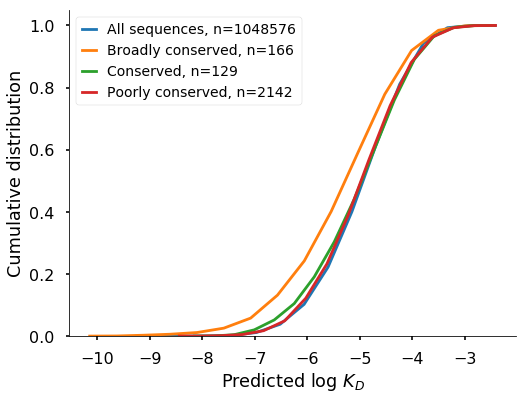

In [74]:
sns.set_context('poster')
human_miRNAs['pred_kd'] = [pred_all_mirs_dict[x] for x in human_miRNAs['10mer']]
fig = plt.figure(figsize=(8,6))
sns.kdeplot(-1 * pred_all_mirs, label='All sequences, n={}'.format(len(pred_all_mirs)), cumulative=True, gridsize=10)
for cons, group in human_miRNAs.groupby('cons'):
#     bins, cdf = get_cdf(group['pred_kd'].values)
#     plt.plot(bins, cdf, label=cons)
    group = group.groupby('10mer').first()
    sns.kdeplot(group['pred_kd'].values, label='{}, n={}'.format(cons, len(group)), cumulative=True, gridsize=10)
    

    
c0 = human_miRNAs[human_miRNAs['cons'] == 'Poorly conserved']['pred_kd'].values
c1 = human_miRNAs[human_miRNAs['cons'] == 'Conserved']['pred_kd'].values
c2 = human_miRNAs[human_miRNAs['cons'] == 'Broadly conserved']['pred_kd'].values

print(stats.mannwhitneyu(c0, c1))
print(stats.mannwhitneyu(c0, c2))

plt.xlabel(r'Predicted log $K_D$')
plt.ylabel('Cumulative distribution')
plt.legend(handlelength=1, fontsize=14)

sns.despine()

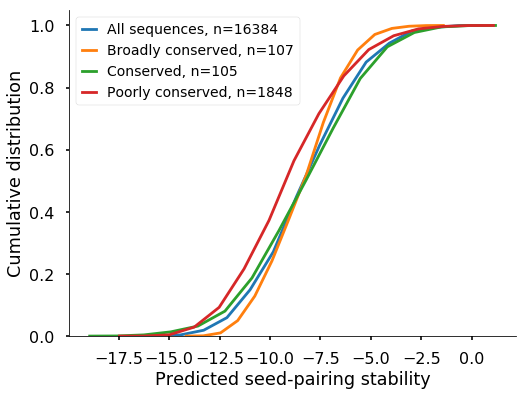

In [73]:
human_miRNAs['SPS'] = TA_SPS.loc[human_miRNAs['Seed+m8'].values]['SPS (8mer and 7mer-m8)'].values
fig = plt.figure(figsize=(8,6))
sns.kdeplot(TA_SPS['SPS (8mer and 7mer-m8)'].values, label='All sequences, n={}'.format(len(TA_SPS)), cumulative=True, gridsize=10)
for cons, group in human_miRNAs.groupby('cons'):
    group = group.groupby('Seed+m8').first()
    sns.kdeplot(group['SPS'].values, label='{}, n={}'.format(cons, len(group)), cumulative=True, gridsize=10)
    

    
# c0 = human_miRNAs[human_miRNAs['cons'] == 'Poorly conserved']['pred_kd'].values
# c1 = human_miRNAs[human_miRNAs['cons'] == 'Conserved']['pred_kd'].values
# c2 = human_miRNAs[human_miRNAs['cons'] == 'Broadly conserved']['pred_kd'].values

# print(stats.mannwhitneyu(c0, c1))
# print(stats.mannwhitneyu(c0, c2))

plt.xlabel(r'Predicted seed-pairing stability')
plt.ylabel('Cumulative distribution')
plt.legend(handlelength=1, fontsize=14)

sns.despine()

In [56]:
human_miRNAs.sort_values('pred_kd', ascending=False).head(20)

,10mer,miR family,Seed+m8,Species ID,MiRBase ID,Mature sequence,Family Conservation?,MiRBase Accession,cons,pred_kd,SPS
153,AATATTATAC,miR-656-3p,AUAUUAU,9606,hsa-miR-656-3p,AAUAUUAUACAGUCAACCUCU,0,MIMAT0003332,Poorly conserved,-2.970354,-1.90
702,CAACACCAGT,miR-21-3p/3591-3p,AACACCA,9606,hsa-miR-21-3p,CAACACCAGUCGAUGGGCUGU,0,MIMAT0004494,Poorly conserved,-3.026245,-7.90
1013,CGGCGCCCGT,miR-6789-3p,GGCGCCC,9606,hsa-miR-6789-3p,CGGCGCCCGUGUCUCCUCCAG,0,MIMAT0027479,Poorly conserved,-3.039431,-14.89
983,CCTGTGGGCC,miR-134-3p,CUGUGGG,9606,hsa-miR-134-3p,CCUGUGGGCCACCUAGUCACCAA,0,MIMAT0026481,Poorly conserved,-3.047838,-10.97
188,ACAAAAAAAA,miR-3613-3p,CAAAAAA,9606,hsa-miR-3613-3p,ACAAAAAAAAAAGCCCAACCCUUC,0,MIMAT0017991,Poorly conserved,-3.066137,-2.22
22,AAAATGAAAT,miR-3646,AAAUGAA,9606,hsa-miR-3646,AAAAUGAAAUGAGCCCAGCCCA,0,MIMAT0018065,Poorly conserved,-3.068606,-3.36
696,CAAATAATAC,miR-5692a,AAAUAAU,9606,hsa-miR-5692a,CAAAUAAUACCACAGUGGGUGU,0,MIMAT0022484,Poorly conserved,-3.108987,-1.33
27,AAACACCATT,miR-21-3p/3591-3p,AACACCA,9606,hsa-miR-3591-3p,AAACACCAUUGUCACACUCCAC,0,MIMAT0019877,Poorly conserved,-3.110533,-7.90
1431,GGGGCCTGGC,miR-2861,GGGCCUG,9606,hsa-miR-2861,GGGGCCUGGCGGUGGGCGG,0,MIMAT0013802,Poorly conserved,-3.142362,-13.30
1413,GGGAGCCAGG,miR-505-5p,GGAGCCA,9606,hsa-miR-505-5p,GGGAGCCAGGAAGUAUUGAUGU,0,MIMAT0004776,Poorly conserved,-3.185470,-11.94


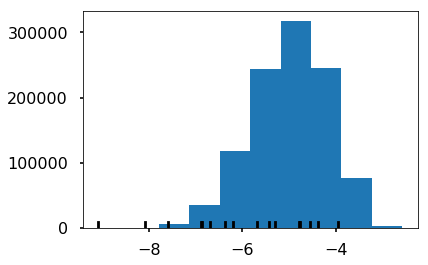

In [54]:
plt.hist(-1 * pred_all_mirs)
vals = human_miRNAs.set_index('MiRBase ID').loc[list(mir_to_name.values())]['pred_kd']
for val in vals:
    plt.plot([val, val], [0,10000], color='black')

In [52]:
seq_dict = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/TS7_input_files/seq_dict.csv',
                       sep='\t').set_index('col')

id_to_batch = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/TS7_input_files/id_to_batch.txt', sep='\t')
id_to_batch['mirseq'] = [x[1:10].replace('U','T') for x in seq_dict.loc[id_to_batch['ID'].values]['mirna_seq'].values]

seq_dict = {x:y for (x,y) in zip(id_to_batch['ID'], id_to_batch['mirseq'])}
batch_dict = {x:y for (x,y) in zip(id_to_batch['mirseq'], id_to_batch['Batch'])}

In [53]:
ts7_train = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/TS7_input_files/TS7_train_set_fold_changes.txt')
ts7_train = ts7_train[ts7_train['RefSeq ID'].isin(MERGED.index)].set_index('RefSeq ID')
ts7_train = ts7_train.drop(['Used in training','Gene symbol'],1)
ts7_train.columns = [seq_dict[x] for x in ts7_train.columns]

ts7_train.head()

,TCGTAGGTC,TCATCTCCA,TGCTCTTTC,TTTGGAACA,TTGGAACAG,CAAACACCA,AATACACCT,TTTCCTCCT,AGCTTCCCG,AGTCAGAGG,TGAGCCCCA,AAGCTTCCC,GGCAGTGAT,TTTCCATTG,AAAGCAGCC,AGGCTGTTG,ATATTTGGC,TACGCGACA,TATCGGACA,ATCGACACA,TAGACCACA,GTACTAACA,GGTACCACA,GATATCACA,ACACACACA,AGGCAGACA,AGGAAAACA,GTTGCTTCA,CTTGATCCA,CAAATCTGC,GAACCTCCA,CACCGTAGA,TTGTAGCCA,CACGATGGA,TTTTGGAAC,GGTGAAGTC,TTGAGGCTG,CAAGTCTCC,GCAAGTCTC,GCGCAAGTC,ATTGCGCAA,ACATTGCGC,CACATTGCG,TCACATTGC,AGTCACATT,CAGTCACAT,GCAGTCACA,AGCAGTCAC,TCAGCAGTC,GTCAGCAGT,ACCGCAGTT,TCCGCAGTT,ACCGTAGTT,ACTGCAGTT,TTACCCTTT,ACACCCTGC,TGTAGAGGA,ACCGCATTT,ACCTCAGTT,ATCGCAGTT,TGACCATGA,TAGGATTCA,TAGTGTCAT,GGAAGACTA,CTTTGGTTA,GGAGTGTGA,CACAGTGAA,AACAGTCTA,TGGTCCCCT,GTAGTGTTT,CAGTGCATC,ACATTCAAC,GGAATGTAA,AAGGCACGC
RefSeq ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NM_000019,-0.009,-0.018,0.008,-0.147,-0.339,0.027,0.157,0.034,-0.115,-0.008,0.017,0.065,-0.035,0.127,-0.131,-0.032,0.062,0.109,0.086,0.078,-0.120,-0.084,0.189,0.094,0.119,-0.006,-0.016,-0.140,0.107,-0.152,0.318,0.204,-0.383,0.132,-0.606,0.029,-0.021,0.032,-0.064,-0.044,0.029,-0.328,-1.457,0.042,0.078,0.044,0.015,0.059,0.054,0.137,0.085,-0.198,0.184,0.521,0.021,0.102,0.138,0.053,0.247,-0.236,0.037,0.339,-0.340,-0.017,0.061,-0.016,0.165,0.150,0.083,-0.040,0.044,0.105,0.041,0.032
NM_000031,-0.010,-0.058,0.165,-0.008,0.121,-0.060,-0.001,-0.034,-0.257,-0.277,0.144,-0.196,-0.025,0.317,-0.254,-0.005,0.125,0.079,0.147,-0.112,-0.227,0.029,0.120,-0.256,-0.010,-0.078,-0.122,0.432,0.443,-0.184,-0.122,0.161,0.029,0.171,-0.136,0.257,-0.246,0.107,0.268,-0.077,-0.048,0.422,0.121,0.092,-0.043,-0.029,-0.160,-0.077,-0.099,0.120,0.049,0.036,-0.152,-0.459,0.019,-0.243,-0.069,-0.039,-0.119,-0.086,-0.106,0.088,0.509,-0.061,-0.341,-0.117,-0.105,-0.001,0.368,0.109,0.055,0.032,-0.021,0.172
NM_000046,0.108,-0.166,0.191,0.174,-0.149,0.216,-0.211,-0.350,-0.154,-0.187,-0.181,0.141,-0.019,0.006,0.112,0.098,0.000,0.023,-0.037,-0.014,0.009,-0.367,-0.059,0.003,-0.004,0.022,0.068,-0.476,-0.545,0.356,-0.462,0.119,0.110,-0.415,0.616,-0.037,0.048,-0.079,-0.122,0.161,-0.056,0.221,-0.052,0.154,-0.024,0.033,-0.021,-0.018,-0.177,0.087,0.141,-0.028,-0.225,0.772,0.092,0.180,-0.099,-0.253,0.090,0.052,-0.016,0.073,-0.034,-0.323,0.100,-0.694,-0.019,0.103,0.004,-0.038,-0.082,-0.305,0.148,-0.023
NM_000064,-0.019,0.049,-0.019,-0.115,0.102,0.172,0.019,-0.118,0.014,-0.247,-0.072,-0.148,-0.002,0.047,-0.044,0.192,0.146,0.100,-0.098,0.024,-0.112,-0.188,0.001,0.051,0.279,0.224,-0.066,-0.370,0.282,0.088,0.029,-0.142,0.324,-0.324,0.134,0.487,-0.122,-0.091,0.029,0.108,0.034,-0.049,-0.152,-0.121,0.079,-0.082,0.165,-0.030,0.027,0.000,0.028,0.073,-0.041,0.435,-0.038,0.221,-0.110,-0.014,-0.337,0.081,0.074,-0.111,-0.103,0.018,-0.142,-0.142,-0.122,0.026,0.652,-0.055,0.112,0.168,-0.302,-0.394
NM_000086,-0.030,0.015,0.045,-0.195,0.008,-0.114,-0.004,0.087,-0.119,-0.016,0.066,0.085,-0.110,0.076,0.145,0.068,-0.012,0.115,0.157,0.002,0.012,-0.083,-0.043,-0.003,0.183,-0.043,0.044,-0.020,-0.078,0.003,0.056,-0.019,-0.045,0.078,-0.076,-0.315,-0.332,-0.100,0.093,0.046,0.035,0.072,-0.012,0.059,-0.034,0.000,-0.326,0.041,0.062,0.204,-0.121,0.181,0.012,-0.008,0.024,-0.018,0.098,-0.069,0.081,0.009,0.116,-0.015,0.158,-0.153,0.246,0.105,0.047,0.087,-0.169,0.055,0.194,-0.045,-0.093,0.170


In [37]:
TA_SPS = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/TS7_input_files/TA_SPS_by_seed_region.txt',
                     sep='\t', index_col='Seed region')
TA_SPS.head()

,SPS (8mer and 7mer-m8),SPS (7mer-1a and 6mer),TA
Seed region,,,
AAAAAAA,-0.59,0.34,4.371
AAAAAAC,-2.35,0.34,4.232
AAAAAAG,-2.19,0.34,4.285
AAAAAAU,-0.76,0.34,4.301
AAAAACA,-3.08,-1.42,4.127


In [85]:
ts7_pairing = []

for col in ts7_train.columns:
    site = helpers.rev_comp(col[:7]) + 'A'
    temp = ts7_train.dropna(subset=[col])
    temp['utr'] = MERGED.loc[temp.index]['sequence'].values
    temp['has_site'] = [site in x for x in temp['utr']]
    temp = temp[temp['has_site']]
    
    if len(temp) == 0:
        med_logfc = np.nan
    else:
        med_logfc = np.mean(temp[col])
    
    ts7_pairing.append([col,
                        'CG' in col,
                    pred_all_mirs_dict[col],
                 med_logfc,
                 batch_dict[col],
                 TA_SPS.loc[col[:7].replace('T','U')]['SPS (8mer and 7mer-m8)'],
                 TA_SPS.loc[col[:7].replace('T','U')]['TA']])
ts7_pairing = pd.DataFrame(ts7_pairing)
ts7_pairing = ts7_pairing[ts7_pairing[1] == False]
ts7_pairing.columns = ['seq','has_CG','pred','logfc','batch','SPS','TA']
ts7_pairing.head()

,seq,has_CG,pred,logfc,batch,SPS,TA
1,TCATCTCCA,False,-4.415729,-0.396243,Anderson 2008,-7.80,3.607
2,TGCTCTTTC,False,-4.564251,-0.298463,Anderson 2008,-7.98,3.586
3,TTTGGAACA,False,-5.391326,-0.120060,Anderson 2008,-5.52,3.709
4,TTGGAACAG,False,-6.112386,-0.183000,Anderson 2008,-7.28,3.635
5,CAAACACCA,False,-6.520975,-0.245333,Anderson 2008,-6.47,3.726


In [86]:
print(stats.linregress(ts7_pairing['pred'], ts7_pairing['logfc']))
print(stats.linregress(ts7_pairing['SPS'], ts7_pairing['logfc']))

LinregressResult(slope=0.015955822260417103, intercept=-0.15692876098899133, rvalue=0.13455070551479081, pvalue=0.31833902618913223, stderr=0.015844722409347294)
LinregressResult(slope=0.021560917680707361, intercept=-0.070806553946699102, rvalue=0.36930082906152717, pvalue=0.0046975420174709655, stderr=0.0073158733699188279)


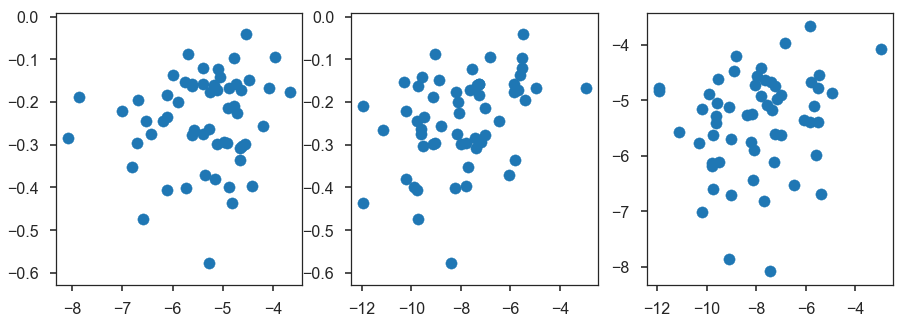

In [87]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
plt.scatter(ts7_pairing['pred'], ts7_pairing['logfc'])
ax = plt.subplot(1,3,2)
plt.scatter(ts7_pairing['SPS'], ts7_pairing['logfc'])
ax = plt.subplot(1,3,3)
plt.scatter(ts7_pairing['SPS'], ts7_pairing['pred'])

In [107]:
temp = human_miRNAs.copy()
temp['pred_kd'] = -1 * pred_human
temp = temp.groupby('miR family').agg({'pred_kd': np.mean})
temp.sort_values('pred_kd', ascending=False)

,pred_kd
miR family,
miR-23-3p/130a-5p,-3.596463
miR-200bc-3p/429,-3.700300
miR-218-5p,-3.808574
miR-302-3p.2/520-3p,-3.925332
miR-139-5p,-3.951602
miR-383-5p.2,-3.984851
miR-141-3p/200a-3p,-3.994951
miR-140-3p.1,-4.018022
miR-128-3p/216-3p/3681-3p,-4.081936


In [119]:
human_seeds = human_miRNAs['Seed+m8'].unique()

In [118]:
all_mirs_pred = pd.DataFrame({'seq': all_mirs, 'pred_kd': -1 * pred_all_mirs})
all_mirs_pred['seed'] = [x[:7].replace('T','U') for x in all_mirs]
all_mirs_pred = all_mirs_pred.groupby('seed').agg({'pred_kd': np.mean})
all_mirs_pred['is_canon'] = [x in human_miRNAs['Seed+m8'].values for x in all_mirs_pred.index]
all_mirs_pred['has_CG'] = ['CG' in x for x in all_mirs_pred.index]
all_mirs_pred = all_mirs_pred[all_mirs_pred['has_CG'] == False]
all_mirs_pred.sort_values('pred_kd').head(20)

,pred_kd,is_canon,has_CG
seed,,,
AAGGCAC,-8.173219,True,False
UAGGUAC,-8.113452,False,False
AAGGUAC,-8.027494,False,False
UAGGCAC,-8.003066,False,False
GUAAGAC,-7.832452,False,False
GGAAUGC,-7.772122,False,False
GCAAGCC,-7.763924,False,False
GGAAGAC,-7.745741,True,False
UACCUAC,-7.720012,False,False


In [50]:
blah = mir1[mir1['pred'] > -2]
print(config.SITE_DICT['mir155'])
blah.sort_values('log_kd').head(20)

AGCATTAA


,pred,log_kd,stype,has_offset,mir
12mer,,,,,
ACCTACCTACCT,-1.824418,-5.040445,6mer-m8,False,let7
ATATACCTCCCG,-1.907515,-4.853208,6mer,False,let7
TCCTACCTACCT,-1.628031,-4.781526,6mer-m8,False,let7
TACTACCTACCT,-1.948789,-4.709677,6mer-m8,False,let7
AAATACCTCCCG,-1.972819,-4.666405,6mer,False,let7
CCCTACCTACCT,-1.374282,-4.645555,6mer-m8,False,let7
TTCTACCTACCT,-1.822199,-4.531043,6mer-m8,False,let7
CACTACCTACCT,-1.790601,-4.476412,6mer-m8,False,let7
ATATACCTCCCC,-1.996166,-4.410921,6mer,False,let7


(-7, 0)

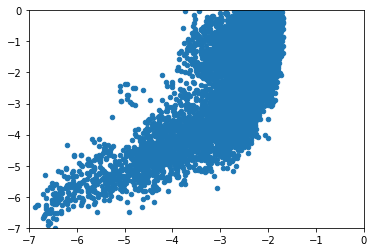

In [22]:
temp = mir1[mir1['stype'] != 'no site']
plt.scatter(temp['pred'], temp['log_kd'], s=20)
plt.xlim(-7,0)
plt.ylim(-7,0)

In [23]:
temp.sort_values('log_kd',ascending=False)

,pred,log_kd,stype
12mer,,,
GGACATTCGCGA,-1.892313,4.252729,6mer-m8
GGACATTCAAGA,-2.634848,3.609218,6mer-m8
GGACATTCAGGG,-2.034496,3.367920,6mer-m8
GGACATTCGGTT,-1.824844,3.347482,6mer-m8
AGACATTCAGGG,-2.202278,3.330598,6mer-m8
GTGGATTCCACG,-1.909766,3.292660,6mer-a1
GGACATTCTGTG,-1.826338,3.132674,6mer-m8
GGACATTCGGAA,-1.924366,3.023967,6mer-m8
GGACATTCGCGG,-1.837117,3.019676,6mer-m8


In [17]:
temp = mir1[mir1['log_kd'] < -4]
temp = temp[temp['pred'] < -4]
stats.linregress(temp['pred'], temp['log_kd'])[2]**2

0.44885260086845402

In [23]:
temp = kds_pred[kds_pred['mir'] == 'mir216b']
print(temp.groupby('stype').agg(np.mean))
temp = temp[temp['stype'] == 'no site']
temp['8mer'] = [x[2:-2] for x in temp['12mer']]
temp.groupby('8mer').agg(np.mean).sort_values('log_kd').head(10)

           log_kd
stype            
6mer    -1.907866
6mer-a1 -1.575348
6mer-m8 -1.295741
7mer-a1 -2.335402
7mer-m8 -2.416360
8mer    -2.879328
no site  0.019059


,log_kd
8mer,
AGTGATTA,-2.045795
AGAAATTA,-2.034663
AGGGATTA,-1.931545
AGATATTA,-1.893268
ATAGATTT,-1.870946
AAAGATTT,-1.817263
AGCGATTA,-1.764226
TGAGATAA,-1.754954
AGTGATTT,-1.744274


In [137]:
def get_cdf(logFC_list):
    """
    Parameters:
    ==========,
    logFC_list: list of floats, list of log fold-change values to plot CDF

    Returns:
    =======
    list of floats: bin indices
    list of floats: cdf values corresponding to the bin indices
    """

    if len(logFC_list) < 4:
        return [], []
    num_bins = int(len(logFC_list)/4)
    counts, bin_edges = np.histogram(logFC_list, bins=num_bins)
    counts = counts / float(sum(counts))
    
    return bin_edges[1:], np.cumsum(counts)

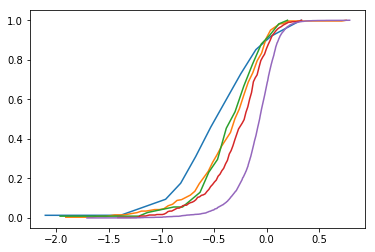

In [32]:
site = config.SITE_DICT['mir216b']
l1, l2, l3, l4, l5 = [], [], [], [], []
for row in MERGED.iterrows():
    utr = row[1]['sequence']
    logfc = row[1]['mir216b'] - row[1]['baseline']
    if site in utr:
        l1.append(logfc)
    elif site[:-1] in utr:
        l2.append(logfc)
    elif site[1:] in utr:
        l3.append(logfc)
    elif site[1:-1] in utr:
        l4.append(logfc)
    else:
        l5.append(logfc)
        
for ln in [l1, l2, l3, l4, l5]:
    bins, cdf = get_cdf(ln)
    plt.plot(bins, cdf)
    

In [66]:
config.SITE_DICT['mir216b'], config.MIRSEQ_DICT['mir216b']

('AGAGATTA', 'AAATCTCTGCAGGCAAATGTGA')

3579


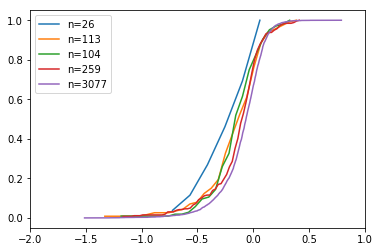

In [65]:
site = 'AGGGATTA'
l1, l2, l3, l4, l5 = [], [], [], [], []
temp = MERGED[MERGED['utr_length'] < 2000]
print(len(temp))
for row in temp.iterrows():
    utr = row[1]['sequence']
    logfc = row[1]['mir216b'] - row[1]['baseline']
    if site in utr:
        l1.append(logfc)
    elif site[:-1] in utr:
        l2.append(logfc)
    elif site[1:] in utr:
        l3.append(logfc)
    elif site[1:-1] in utr:
        l4.append(logfc)
    else:
        l5.append(logfc)
        
for ln in [l1, l2, l3, l4, l5]:
    bins, cdf = get_cdf(ln)
    plt.plot(bins, cdf, label='n={}'.format(len(ln)))
    
plt.xlim(-2,1)
plt.legend()

0.16388527540593006

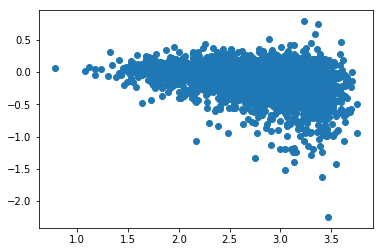

In [50]:
temp = MERGED.dropna(subset=['nosite3'])
xs = np.log10(temp['utr_length'].values)
ys = temp['mir216b'].values - temp['baseline'].values
plt.scatter(xs, ys)
stats.linregress(xs, ys)[2]**2

In [68]:
preds = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/convnet_preds.txt',
                    sep='\t',index_col=0)
preds.head()

,log2_bayes_intercept,log2_tpm,log2fc_bayes,log2fc_method3,mir,nosite3,num_canon,pred
NM_000019,8.093441,7.800049,-0.293393,-0.259898,mir137,8.059946,0,-0.031005
NM_000031,4.831326,4.601823,-0.229503,-0.187901,mir137,4.789724,2,-0.546857
NM_000046,5.749622,5.542175,-0.207447,-0.300949,mir137,5.843124,0,-0.010194
NM_000064,3.457240,3.442316,-0.014924,-0.395490,mir137,3.837806,0,-0.004966
NM_000086,6.307849,6.306735,-0.001114,-0.186122,mir137,6.492857,0,-0.014487


In [78]:
temp = preds[preds['mir'] == 'mir216b']
temp = temp[temp['num_canon'] == 0]
temp.sort_values('pred')

,log2_bayes_intercept,log2_tpm,log2fc_bayes,log2fc_method3,mir,nosite3,num_canon,pred
NM_005909,8.914813,7.050445,-1.864368,NaN,mir216b,NaN,0,-0.806245
NM_032582,6.901920,6.175891,-0.726028,-0.306033,mir216b,6.481924,0,-0.730935
NM_003489,6.371195,5.795157,-0.576038,NaN,mir216b,NaN,0,-0.710937
NM_016248,7.117979,5.639720,-1.478259,NaN,mir216b,NaN,0,-0.710276
NM_018590,5.685513,5.003735,-0.681778,-1.283875,mir216b,6.287610,0,-0.667690
NM_007347,4.679647,4.238940,-0.440707,NaN,mir216b,NaN,0,-0.665372
NM_018084,7.230174,6.437661,-0.792513,NaN,mir216b,NaN,0,-0.662964
NM_003930,5.283422,3.597994,-1.685429,NaN,mir216b,NaN,0,-0.651090
NM_016315,7.567246,7.354886,-0.212360,0.097570,mir216b,7.257316,0,-0.645231
NM_015313,7.818124,7.144786,-0.673339,-0.108835,mir216b,7.253621,0,-0.637629


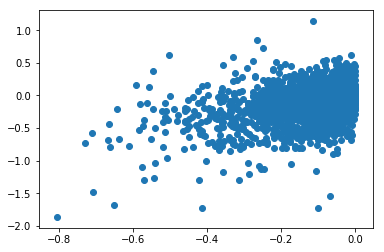

In [72]:
plt.scatter(temp['pred'], temp['log2fc_bayes'])

In [73]:
MERGED.loc['NM_005909']['sequence']

'AAACCAAGGCCAGCCACACCACAGGATCTGAACTTTGTTTCCAGAAATTCTTCAATTTGAAATCACCTTTTCTAAAAAGTCAATTCATCTAGTTAAGTCGCTGAACAATTACCTGCCAAATGCTATACTGTGTCATGGTGATGCAAGTCACTAAATTTCTCAGTTTTTGCTGATTGCTAAGGGAAATAACAGTATTTCCACAATAGGGTTCAAATTCCTGCAAAATTACCTACCCCAGTTCATCTCTGCTGAACATTTGGAAACCATGCACTAGCCAACCCAACTGACTTCTGCTAGGTAGAGGCATTTGTCTTAGAGAGAGAGAGAGCGCGGGAGAGAGTGAGAGAGAGTGAGAGCACAAAGATAACGCAGGAGAGAGAGAGAGAAAGAATGAGAAAGAAAAGGAATGCAAGAGAAGGAGATGTAATGACAGAGAGTTCTGGTGAGATACCCAGAGAGAAAAAGAGAGAGCAGGGTGGGGTAAGGAGGAGAAAATAAACCAACAATTAGGTCTGCATTTTCTCAGGCAGTAGGCATTCTTTAGTCTACATAGGCAAAGTTTTCCATTTTTGTCAGTCTGAGTCATCAAAAAGAGTCTTAATTTTCTAAAACAAGTTGGCTAGAAGAAAGTAAAAAGAACAACACTTGTTATGAGGGCATGTGATATTTTCACATCTTAATTAAGCTCCTTCAGTTTGAAGGCTGCACACTGACATAATGTAGTGAGTGTAGACTGGCCATGCAAGTGGTTTGGGCCCCATTCAGAACTCTCAGACTCTAAACACACAAGTAGATTGATCTAAGGCATGCTCCCAGCATTTGTCCACCCACTTAGTCCACTCTGAGTCGATTAACCTGCATGCAGCAACACCCAAGTCCACCCCAATTAACTGAAGCAAATACCAAAGCAGTTGGGAGTACATATGGTAGACAATTTGCCTTAGGAAGTGACTTGAATGTACAAAGATACTTGATGCACTTATTTTTTAATGTGAGACA

In [75]:
config.SITE_DICT['mir216b'], config.MIRSEQ_DICT['mir216b']

('AGAGATTA', 'AAATCTCTGCAGGCAAATGTGA')